### 循环神经网络模型模型：Encoder-Decoder with LSTM cell

0.747 gene MAE

0.73 transplant MAE

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder

random.seed(42)

读取数据

In [2]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/es_with_decay.array'
transplant_arr_path = r'../output/transplant/es_with_decay.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 10)
Shape of the transplant array: (5141, 17, 10)


### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [3]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 10)
Shape of the transplant array: (5141, 16, 10)


### 规范数据并获取训练集和测试集

In [11]:
# scaler, data = scale_data(gene_arr, 'standard')
scaler, data = scale_data(transplant_arr, 'standard')
X_train, X_test, y_train, y_test = split_data(data, n_input=11, ratio=0.2)

# X_train, X_test, y_train, y_test = split_data(transplant_arr, n_input=11, ratio=0.2)
# _, X_train = scale_data(X_train, 'standard')
# _, X_test = scale_data(X_test, 'standard')

In [12]:
# Teacher forcing的模型专用
decoder_in_training = np.roll(y_train, 1, axis=1)
decoder_in_training[:, 0] = 0.0
decoder_in_training = decoder_in_training.reshape(len(decoder_in_training), -1, 1)

decoder_in_validation = np.roll(y_test, 1, axis=1)
decoder_in_validation[:, 0] = 0.0
decoder_in_validation = decoder_in_validation.reshape(len(decoder_in_validation), -1, 1)

enc = OneHotEncoder(categories='auto')

train_ids = np.arange(len(X_train)).reshape(-1, 1)
test_ids = np.arange(len(X_test)).reshape(-1, 1)
train_ids = enc.fit_transform(train_ids).toarray()
test_ids = enc.fit_transform(test_ids).toarray()

### 构建模型

In [6]:
def build_encoder_decoder_model(lstm_units, dense_units, lr):
    model = keras.models.Sequential()
    model.add(LSTM(lstm_units, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(lstm_units, activation='tanh'))
    model.add(RepeatVector(y_train.shape[1]))
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=True))
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(dense_units, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    
    optimizer=keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mae', optimizer=optimizer)
    return model

In [7]:
def build_tf_encoder_decoder_model(input_dims, output_dims, lstm_units):
    # 训练模式
    # encoder，获取其隐藏状态，丢弃其输出
    enc_inputs = Input(shape=(None, input_dims))
    enc = LSTM(lstm_units, return_state=True, dropout=0.2)
    enc_outputs, state_h, state_c = enc(enc_inputs)
    enc_states = [state_h, state_c]
    
    # decoder，输入encoder的隐藏状态和目标序列的往后平移1位的输入，以一个开始标记开始
    dec_inputs = Input(shape=(None, output_dims))
    dec = LSTM(lstm_units, return_sequences=True, return_state=True, dropout=0.2)
    dec_outputs, _, _ = dec(dec_inputs, initial_state=enc_states)
    
    # dense输出
    dec_dense = Dense(output_dims, activation=None)
    dec_outputs = dec_dense(dec_outputs)
    
    model = Model([enc_inputs, dec_inputs], dec_outputs)
    
    # 推断模式，重用了上面的层，下面的模型只需要predict而不需要train
    # encoder很简单，一样的
    enc_model = Model(enc_inputs, enc_states)
    
    # decoder和前面不同的是需要接收自己的隐藏状态（第一次为encoder的隐藏状态），
    # 这里的shape为什么是这样？
    dec_state_input_h = Input(shape=(lstm_units,))
    dec_state_input_c = Input(shape=(lstm_units,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_outputs, state_h, state_c = dec(dec_inputs, initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    dec_outputs = dec_dense(dec_outputs)
    
    dec_model = Model([dec_inputs] + dec_states_inputs,
                     [dec_outputs] + dec_states)
    
    model.compile(optimizer='rmsprop', loss='mae')
    
    return model, enc_model, dec_model

def predict_seq(enc_model, dec_model, input_seq, pred_steps):
    # 先encode序列，获得encoder的隐藏状态
    enc_states = enc_model.predict(input_seq)
    
    # 生成一个形状为(samples, timesteps, output_dims)的占位序列，该序列由开始标记开始
    # 这里我们一步步进行
    # 开始标记的选择也是个问题，暂时用0.0
    target_seq = np.zeros((1, 1, 1))
    target_seq[0, 0, 0] = 0.0
    
    output_seq = []
    for _ in range(pred_steps):
        single_out, h, c = dec_model.predict([target_seq] + enc_states)
        
        output_seq.append(single_out[0, 0, 0])
        
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = single_out[0, 0, 0]
        
        enc_states = [h, c]
    
    return output_seq

训练

In [8]:
model = build_encoder_decoder_model(256, 256, 0.001)
history = model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1, validation_data=(X_test, y_test), 
                   callbacks=[
                       EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto', restore_best_weights=True)
                   ])

Train on 2114 samples, validate on 529 samples
Epoch 1/20
2114/2114 [==============================] - 22s 11ms/sample - loss: 0.0357 - val_loss: 0.0499
Epoch 2/20
2114/2114 [==============================] - 11s 5ms/sample - loss: 0.0326 - val_loss: 0.0347
Epoch 3/20
2114/2114 [==============================] - 11s 5ms/sample - loss: 0.0318 - val_loss: 0.0341
Epoch 4/20
2114/2114 [==============================] - 11s 5ms/sample - loss: 0.0315 - val_loss: 0.0335
Epoch 5/20
2114/2114 [==============================] - 11s 5ms/sample - loss: 0.0315 - val_loss: 0.0335
Epoch 6/20
2114/2114 [==============================] - 11s 5ms/sample - loss: 0.0315 - val_loss: 0.0330
Epoch 7/20
2114/2114 [==============================] - 11s 5ms/sample - loss: 0.0312 - val_loss: 0.0316
Epoch 8/20
2114/2114 [==============================] - 11s 5ms/sample - loss: 0.0310 - val_loss: 0.0316
Epoch 9/20
2114/2114 [==============================] - 11s 5ms/sample - loss: 0.0309 - val_loss: 0.0323
Epoch 1

In [36]:
model, encoder_model, decoder_model = build_tf_encoder_decoder_model(input_dims=10, output_dims=1, lstm_units=512)
history = model.fit([X_train, decoder_in_training], y_train, 
                    epochs=100, validation_data=([X_test, decoder_in_validation], y_test), batch_size=16,
                    callbacks=[
                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto', restore_best_weights=True)
                    ])

Train on 4112 samples, validate on 1029 samples
Epoch 1/100
4112/4112 [==============================] - 30s 7ms/sample - loss: 0.4948 - val_loss: 0.4428
Epoch 2/100
4112/4112 [==============================] - 25s 6ms/sample - loss: 0.4708 - val_loss: 0.4423
Epoch 3/100
4112/4112 [==============================] - 25s 6ms/sample - loss: 0.4646 - val_loss: 0.4353
Epoch 4/100
4112/4112 [==============================] - 25s 6ms/sample - loss: 0.4641 - val_loss: 0.4343
Epoch 5/100
4112/4112 [==============================] - 26s 6ms/sample - loss: 0.4601 - val_loss: 0.4351
Epoch 6/100
4112/4112 [==============================] - 26s 6ms/sample - loss: 0.4605 - val_loss: 0.4308
Epoch 7/100
4112/4112 [==============================] - 26s 6ms/sample - loss: 0.4597 - val_loss: 0.4323
Epoch 8/100
4112/4112 [==============================] - 26s 6ms/sample - loss: 0.4575 - val_loss: 0.4321
Epoch 9/100
4112/4112 [==============================] - 25s 6ms/sample - loss: 0.4576 - val_loss: 0.434

预测

In [13]:
# model.save(r'trained_models/gene_rnn_0.747.h5')
# model.save('transplant_rnn_0.736.h5')
model = keras.models.load_model(r'trained_models/unified/transplant_rnn_0.736.h5')

In [14]:
train_pred = model.predict(X_train).reshape(y_train.shape)
y_pred = model.predict(X_test).reshape(y_test.shape)

# y_pred = list()
# for i in range(X_test.shape[0]):
#     y_pred.append(predict_seq(encoder_model, decoder_model, X_test[i:i+1], pred_steps=5))
# y_pred = np.array(y_pred)

# train_pred = list()
# for i in range(X_train.shape[0]):
#     train_pred.append(predict_seq(encoder_model, decoder_model, X_train[i:i+1], pred_steps=5))
# train_pred = np.array(train_pred)

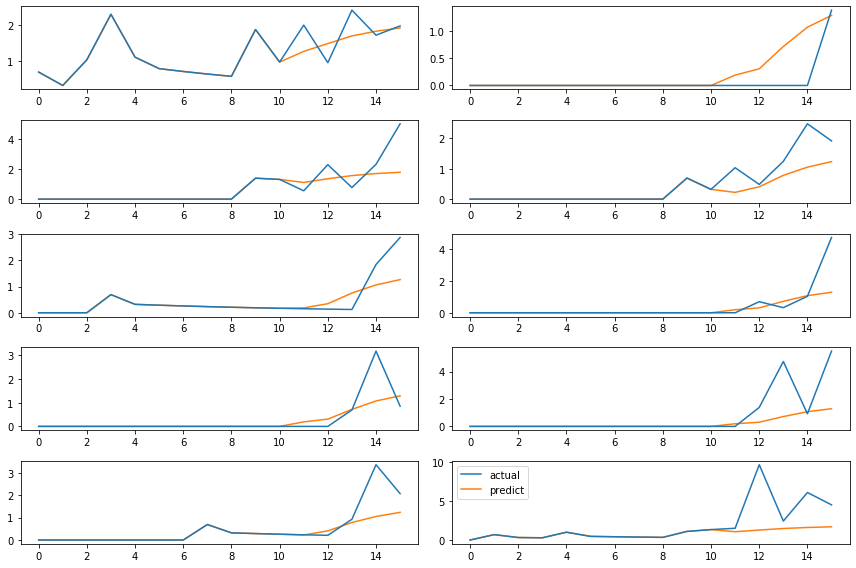

In [24]:
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((scaler.inverse_transform(np.expand_dims(X_test[ids[i], :, -2], axis=0)), scaler.inverse_transform(np.expand_dims(y_test[ids[i]].reshape(-1), axis=0))), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((scaler.inverse_transform(np.expand_dims(X_test[ids[i], :, -2], axis=0)), scaler.inverse_transform(np.expand_dims(y_pred[ids[i]].reshape(-1), axis=0))), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

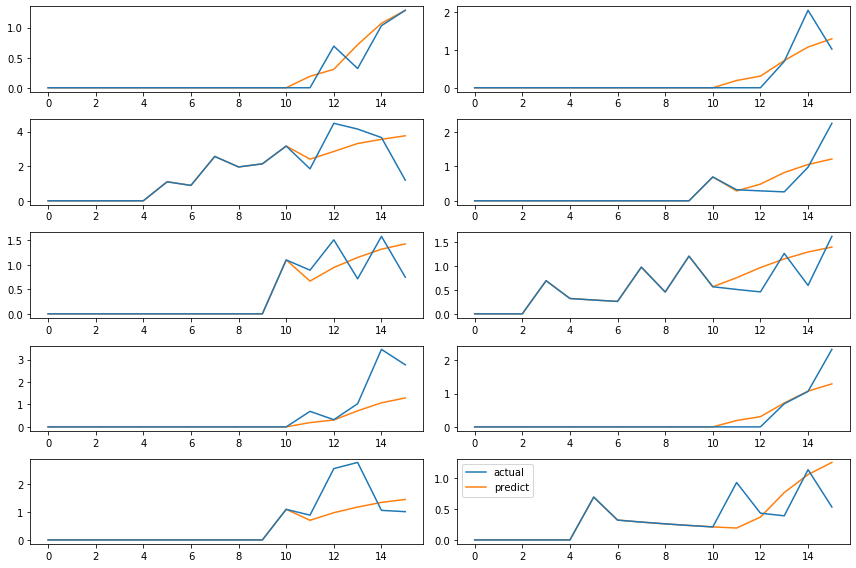

In [26]:
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((scaler.inverse_transform(np.expand_dims(X_train[ids[i], :, -2], axis=0)), scaler.inverse_transform(np.expand_dims(y_train[ids[i]].reshape(-1), axis=0))), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((scaler.inverse_transform(np.expand_dims(X_train[ids[i], :, -2], axis=0)), scaler.inverse_transform(np.expand_dims(train_pred[ids[i]].reshape(-1), axis=0))), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

MAE: 0.7364237570502705
MAE: [0.70185311 0.73379222 0.74523764 0.71146288 0.78977293]


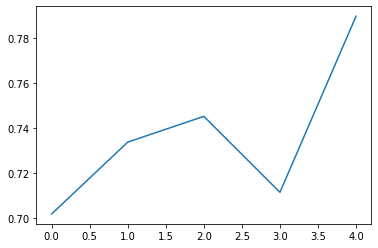

NDCG: 0.3461465593299942
NDCG: [0.09413408067717796, 0.0012481113538171556, 0.060584281932962405, 0.04255531664363994, 0.2015002776053619]


C:\Users\Tom Leung\OneDrive\文件\武汉大学\硕士投稿\主题热度预测\program\utils.py:36: RuntimeWarning: invalid value encountered in true_divide
  pred_score = np.sum((2 ** pred_array[:, 1] - 1) / np.log2(pred_array[:, 0] + 1))


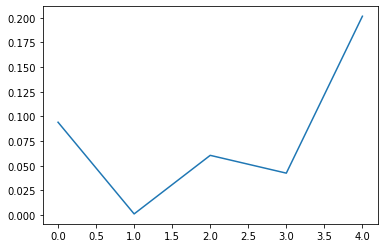

RMSE: 1.1813827565088957
RMSE: [1.11404131 1.22200527 1.20717559 1.15596365 1.2043323 ]


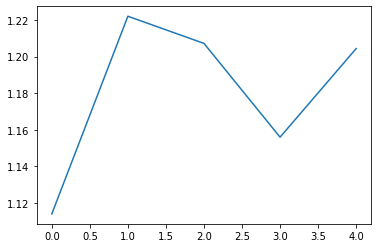

In [15]:
metrics = ['mae', 'ndcg','rmse']

for m in metrics:
    overall, annual = eval_model(m, y_test, y_pred.reshape(len(y_test), -1), scaler)
    print('{}:'.format(m.upper()), overall)
    print('{}:'.format(m.upper()),annual)
    plt.plot(annual)
    plt.show()

In [34]:
_y_true, _y_pred = eval_model('classification', y_test, y_pred, scaler)

In [14]:
from sklearn.metrics import classification_report
print(classification_report(_y_true.reshape(-1), _y_pred.reshape(-1)))

              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59        27
         1.0       0.69      0.67      0.68      3248
         2.0       0.18      0.18      0.18      1059
         3.0       0.40      0.34      0.37       548
         4.0       0.21      0.28      0.24       263

    accuracy                           0.52      5145
   macro avg       0.38      0.50      0.41      5145
weighted avg       0.53      0.52      0.52      5145

